# CNN Visualiseringslabb - Feature Attribution & Visualization

## Introduction
Denna notebook utforskar convolutional neural networks (CNNs) genom visualisering av deras inre arbetssätt. Vi kommer att undersöka:
- Feature attribution med CAM (Class Attribution Map)
- Visualization av aktiveringar i olika lager
- Hur nätverket "ser" och tolkar bilder

**Mål för betyg G:**
- Visualisera minst två lager
- Testa på minst två bilder
- Använda torch-cam för attribution

**Mål för betyg VG:**
- Allt från G + gradient ascent implementation
- Activation maximization
- Fördjupad analys av filter

## 1. Import och Setup

In [20]:
# Importera nödvändiga bibliotek
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# För CAM visualisering - GradCAM för VGG16
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Använder device: {device}')

Använder device: cpu


## 2. Ladda Förtränad Modell

In [21]:
# Ladda förtränad VGG16 modell
model = models.vgg16(pretrained=True)
model = model.to(device)
model.eval()  # Sätt till evalueringsläge

print("VGG16 modell laddad!")
print("Modellstruktur:")
print(model)

VGG16 modell laddad!
Modellstruktur:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si

## 3. Bildförberedelse

In [22]:
# Definiera transforms för bilder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Funktion för att ladda och preprocessa bild
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    return image, input_tensor

# Funktion för att visa bild
def show_image(image, title="Bild"):
    plt.figure(figsize=(8, 6))
    if isinstance(image, torch.Tensor):
        # Konvertera från tensor till numpy
        image = image.cpu().squeeze().permute(1, 2, 0).numpy()
        # Un-normalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Bildfunktioner redo!")

Bildfunktioner redo!


## 4. Ladda Testbilder

Laddade bild: images/Chicko.jpg
Laddade bild: images/Idun.jpg


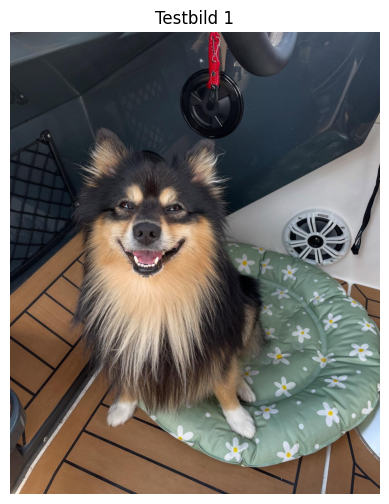

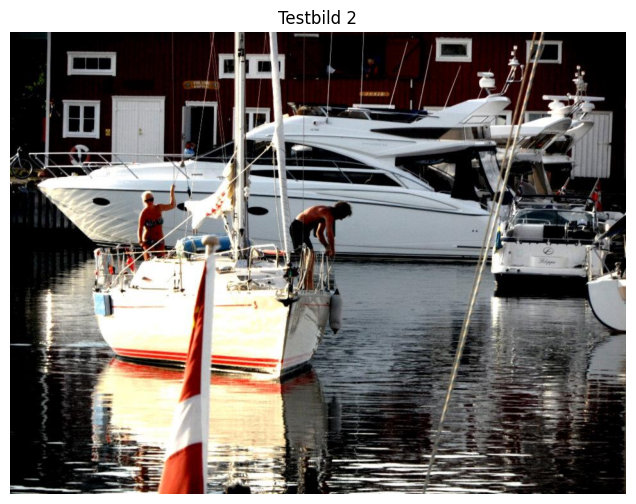

In [23]:
# Sökvägar till testbilder
image_paths = [
    "images/Chicko.jpg",
    "images/Idun.jpg"
]

# Skapa mapp för bilder om den inte finns
os.makedirs("images", exist_ok=True)

# Ladda bilder (om de finns)
images = []
input_tensors = []

for path in image_paths:
    if os.path.exists(path):
        img, tensor = load_and_preprocess_image(path)
        images.append(img)
        input_tensors.append(tensor)
        print(f"Laddade bild: {path}")
    else:
        print(f"Varning: Bilden {path} hittades inte")

# Visa laddade bilder
for i, img in enumerate(images):
    show_image(img, f"Testbild {i+1}")

## 5. CAM Visualisering - Förberedelse

In [24]:
# Funktion för att skapa och visa CAM med GradCAM
def visualize_cam(model, input_tensor, target_layer, class_idx=None, image_index=0):
    """
    Visualisera Class Activation Map för ett specifikt lager med GradCAM
    
    Args:
        model: Tränad modell
        input_tensor: Input tensor för bilden
        target_layer: Lagernamn att visualisera
        class_idx: Specifik klass (valfritt)
        image_index: Index för bilden i images-listan (för rätt overlay)
    """
    # Skapa GradCAM extraktor
    cam_extractor = GradCAM(model, target_layer=target_layer)
    
    # Sätt modellen i eval-läge men behåll gradients
    model.eval()
    
    # Få prediction från modellen
    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()
    
    print(f"Predicerad klass: {class_idx} (confidence: {torch.softmax(output, dim=1)[0, class_idx]:.4f})")
    
    # Nollställ gradients
    model.zero_grad()
    
    # Bakåtpassning för att få gradients
    class_score = output[0, class_idx]
    class_score.backward(retain_graph=True)
    
    # Extrahera CAM
    activation_map = cam_extractor(class_idx, output)
    
    # Konvertera activation map till PIL för overlay_mask
    from torchvision.transforms.functional import to_pil_image
    cam_pil = to_pil_image(activation_map[0].squeeze(), mode='F')
    
    # Konvertera till numpy och overlay på RÄTT bild
    result = overlay_mask(images[image_index], cam_pil, alpha=0.5)
    
    # Visa resultat
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(images[image_index])
    plt.title("Originalbild")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(activation_map[0].squeeze(), cmap='jet')
    plt.title(f"GradCAM - {target_layer}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return activation_map

print("GradCAM funktion redo!")

GradCAM funktion redo!


## 6. Visualisera Lager (G-krav)

Här visualiserar vi två olika lager i VGG16:

Visualiserar lager: features.14 och features.28

=== Visualisering för Chicko ===

Lager 1: features.14
Predicerad klass: 230 (confidence: 0.6762)


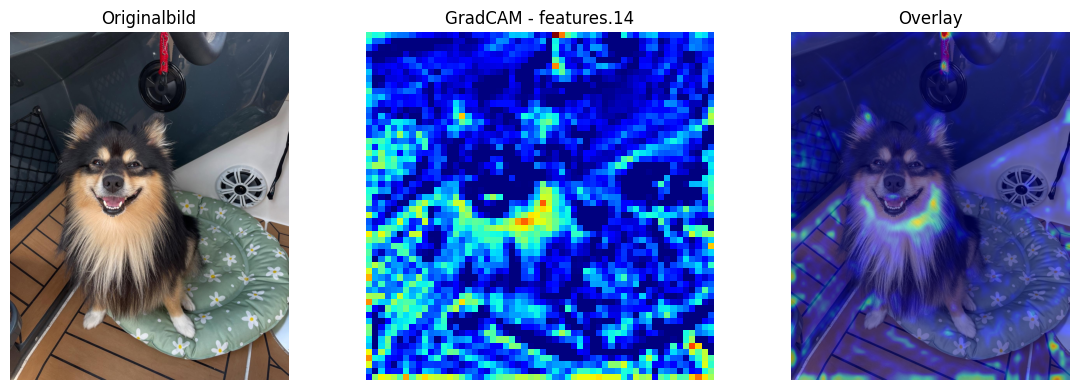


Lager 2: features.28
Predicerad klass: 230 (confidence: 0.6762)


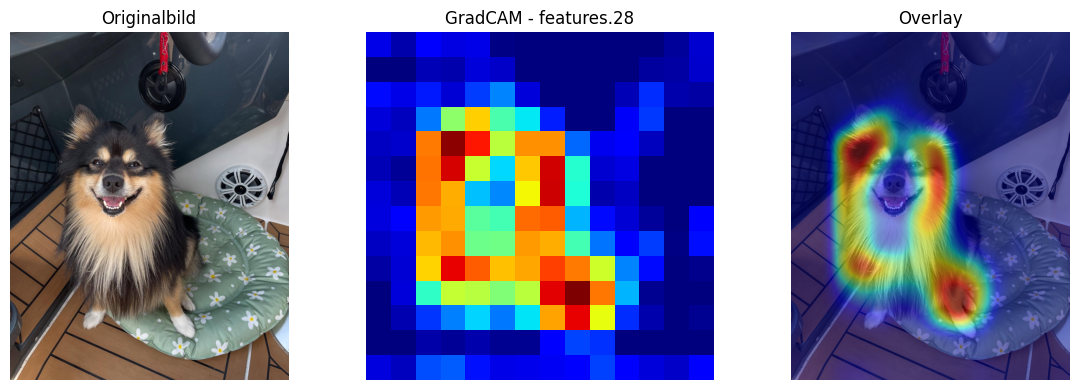

In [25]:
# Välj två lager att visualisera
# VGG16 har följande structure: features (conv-lager) och classifier (fc-lager)

# Lager 1: Ett tidigt conv-lager (features.14 är conv3_2 i VGG16)
layer1 = "features.14"

# Lager 2: Ett djupare conv-lager (features.28 är conv5_1 i VGG16)
layer2 = "features.28"

print(f"Visualiserar lager: {layer1} och {layer2}")

# Visualisera för första bilden (Chicko)
if len(input_tensors) > 0:
    print("\n=== Visualisering för Chicko ===")
    print(f"\nLager 1: {layer1}")
    cam1 = visualize_cam(model, input_tensors[0], layer1, image_index=0)
    
    print(f"\nLager 2: {layer2}")
    cam2 = visualize_cam(model, input_tensors[0], layer2, image_index=0)
else:
    print("Inga bilder laddade - lägg till bilder i images-mappen")

## 7. Visualisera för Andra Bilden


=== Visualisering för Idun ===

Lager 1: features.14
Predicerad klass: 871 (confidence: 0.6949)


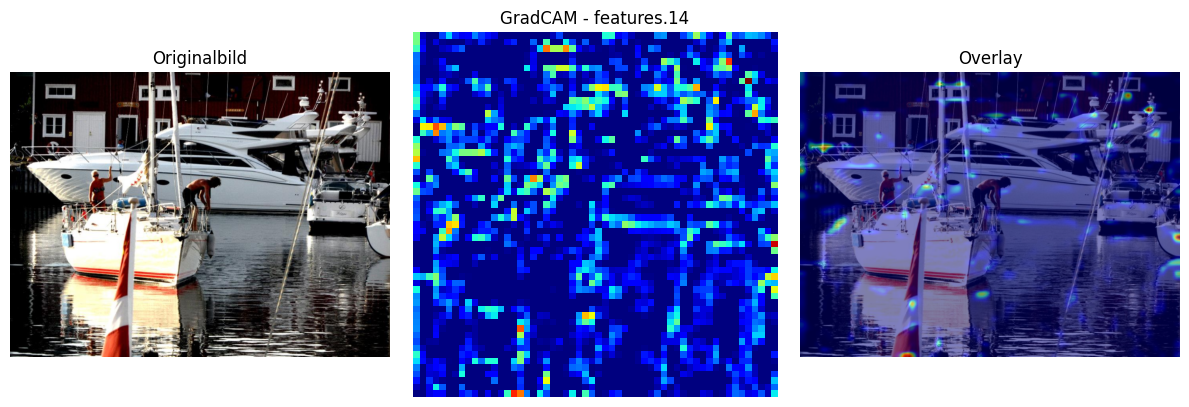


Lager 2: features.28
Predicerad klass: 871 (confidence: 0.6949)


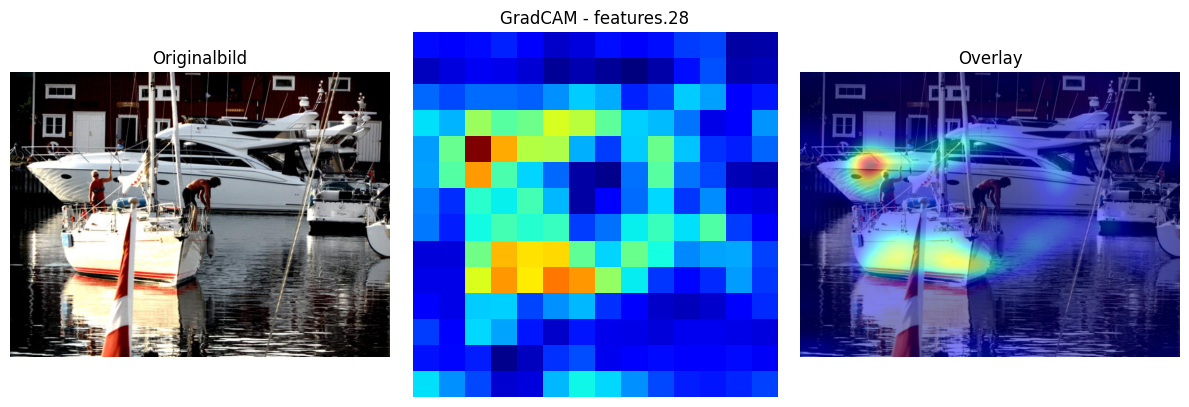

In [26]:
# Visualisera för andra bilden (Idun)
if len(input_tensors) > 1:
    print("\n=== Visualisering för Idun ===")
    print(f"\nLager 1: {layer1}")
    cam1_bild2 = visualize_cam(model, input_tensors[1], layer1, image_index=1)
    
    print(f"\nLager 2: {layer2}")
    cam2_bild2 = visualize_cam(model, input_tensors[1], layer2, image_index=1)
else:
    print("Endast en bild tillgänglig")

## 8. Analys och Resultat

### Motivering av valda lager:
1. **features.14 (conv3_2)**: Ett medeldjupt lager som fångar mellanliggande features som kanter, texturer och enkla former.
2. **features.28 (conv5_1)**: Ett djupt lager som fångar mer abstrakta features och objektdelar.

### Observationer:
- Tidiga lager fokuserar på enkla mönster
- Djupare lager fokuserar på mer komplexa och semantiska features
- CAM visar vilka delar av bilden som är viktigast för klassificeringen

## 9. Slutsats

Denna visualisering visar hur CNNs bygger upp en hierarki av features från enkla till komplexa. CAM-tekniken hjälper oss att förstå varför modellen fattar visst beslut genom att highlighta viktiga regioner i bilden.